In [ ]:
# install
!pip install category_encoders
!pip install eli5
!pip install pdpbox
!pip install shap

In [ ]:
# warning ignore
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# import library
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import dates

from sklearn.model_selection import train_test_split, RandomizedSearchCV, validation_curve
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, TargetEncoder, OrdinalEncoder
from scipy.stats import uniform
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

import shap

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# dataset upload
df = pd.read_csv('energy.csv', encoding='cp949')

## 데이터 탐색

In [4]:
df.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [5]:
# check data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   num         122400 non-null  int64  
 1   date_time   122400 non-null  object 
 2   전력사용량(kWh)  122400 non-null  float64
 3   기온(°C)      122400 non-null  float64
 4   풍속(m/s)     122400 non-null  float64
 5   습도(%)       122400 non-null  float64
 6   강수량(mm)     122400 non-null  float64
 7   일조(hr)      122400 non-null  float64
 8   비전기냉방설비운영   122400 non-null  float64
 9   태양광보유       122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB


In [ ]:
df.isnull().sum()

num           0
date_time     0
전력사용량(kWh)    0
기온(°C)        0
풍속(m/s)       0
습도(%)         0
강수량(mm)       0
일조(hr)        0
비전기냉방설비운영     0
태양광보유         0
dtype: int64

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.describe(include='all')

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
count,122400.000000,122400,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000
unique,NaN,2040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2020-06-01 00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,30.500000,NaN,2324.830866,24.251713,2.151641,80.169848,0.514989,0.213533,0.683333,0.483333
std,17.318173,NaN,2058.999326,3.407902,1.514475,15.525862,2.624505,0.370517,0.465178,0.499724
min,1.000000,NaN,0.000000,11.100000,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000
25%,15.750000,NaN,1055.268000,21.800000,1.100000,70.000000,0.000000,0.000000,0.000000,0.000000
50%,30.500000,NaN,1700.352000,24.200000,1.900000,84.000000,0.000000,0.000000,1.000000,0.000000
75%,45.250000,NaN,2780.487000,26.500000,2.900000,93.000000,0.000000,0.300000,1.000000,1.000000


> 🔎 간단한 데이터 탐색 결과
- 10 행/122,400 열
- 결측치, 중복값 없음
- 컬렴명 변경
- num: 건물번호이므로 string 처리
- date_time: 요일/시간 추출
 - time: 시간은 다시 6시간 단위의 카테고리로 분리(0 ~ 5 = 1 / 6 ~ 11 = 2 / 12 ~ 17 = 3 / 18 ~ 23 = 4)
 - weekend: 주중/주말 구분하는 feature 추가
- 불필요한 컬럼 제거

In [ ]:
df = df.rename(columns={'전력사용량(kWh)' : 'energy', '기온(°C)' : 'temp', '풍속(m/s)' : 'windspeed', 
                       '습도(%)' : 'humidity', '강수량(mm)' : 'precipitation', '일조(hr)' : 'sunshine', 
                       '비전기냉방설비운영' : 'non_elec_ac', '태양광보유' : 'pv'})

In [ ]:
df

,num,date_time,energy,temp,windspeed,humidity,precipitation,sunshine,non_elec_ac,pv
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0


## Feature Engineering

In [ ]:
def engineer_features(df):

    # pandas.DataFrame.copy()
    df = df.copy()

    # num 타입 변환
    df['num'] = df['num'].astype('str')
    
    # timecat column 생성
    df['date_time'] = pd.to_datetime(df['date_time'])
    group1 = df['date_time'].dt.hour<6
    group2 = (df['date_time'].dt.hour>=6) & (df['date_time'].dt.hour<12)
    group3 = (df['date_time'].dt.hour>=12) & (df['date_time'].dt.hour<18)
    group4 = df['date_time'].dt.hour>=18

    df.loc[group1, 'timecat'] = 'night'
    df.loc[group2, 'timecat'] = 'morning'
    df.loc[group3, 'timecat'] = 'afternoon'
    df.loc[group4, 'timecat'] = 'evening'

    # weekend column 생성
    df['dayOfweek'] = df['date_time'].dt.dayofweek
    df['weekend'] = 0
    df.loc[df['dayOfweek'] >= 5, 'weekend'] = 1

    # non_elec_ac, pv 타입 변환
    df['non_elec_ac'] = df['non_elec_ac'].astype('int')
    df['pv'] = df['pv'].astype('int')

    # 불필요한 컬럼 제거
    df = df.drop(['date_time', 'dayOfweek'], axis=1)

    return df

In [ ]:
df_processed = engineer_features(df)

In [ ]:
df_processed

,num,energy,temp,windspeed,humidity,precipitation,sunshine,non_elec_ac,pv,timecat,weekend
0,1,8179.056,17.6,2.5,92.0,0.8,0.0,0,0,night,0
1,1,8135.640,17.7,2.9,91.0,0.3,0.0,0,0,night,0
2,1,8107.128,17.5,3.2,91.0,0.0,0.0,0,0,night,0
3,1,8048.808,17.1,3.2,91.0,0.0,0.0,0,0,night,0
4,1,8043.624,17.0,3.3,92.0,0.0,0.0,0,0,night,0
...,...,...,...,...,...,...,...,...,...,...,...
122395,60,4114.368,27.8,2.3,68.0,0.0,0.7,1,1,evening,0
122396,60,3975.696,27.3,1.2,71.0,0.0,0.0,1,1,evening,0
122397,60,3572.208,27.3,1.8,71.0,0.0,0.0,1,1,evening,0
122398,60,3299.184,27.1,1.8,74.0,0.0,0.0,1,1,evening,0


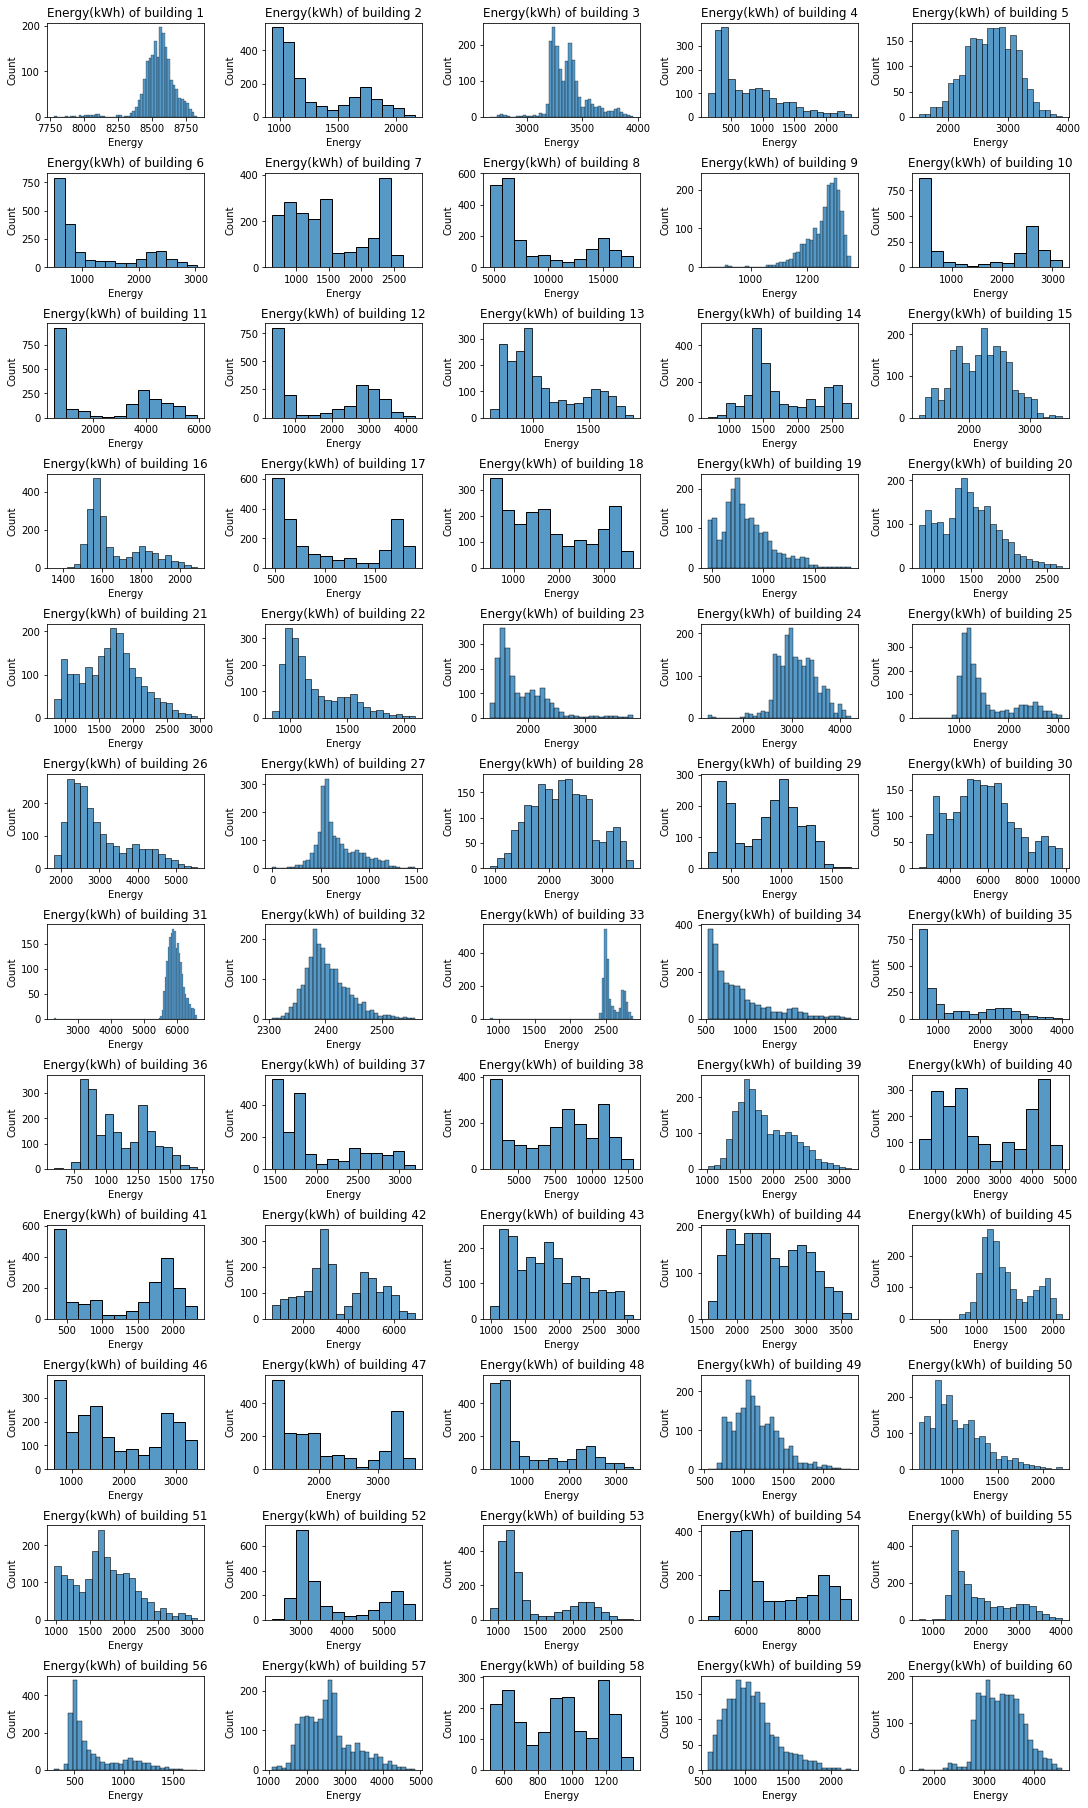

In [ ]:
# 건물에 따른 타겟값 분포
fig, ax = plt.subplots(12, 5, figsize=(15,25), constrained_layout=True)
for i in range(1, 61, 1):
  str_i = str(i)
  x = (i-1)//5
  y = (i-1)%5
  sns.histplot(df_processed[df_processed.num==str_i]['energy'], ax=ax[x, y]);
  ax[x, y].set(xlabel='Energy', title='Energy(kWh) of building '+str_i);

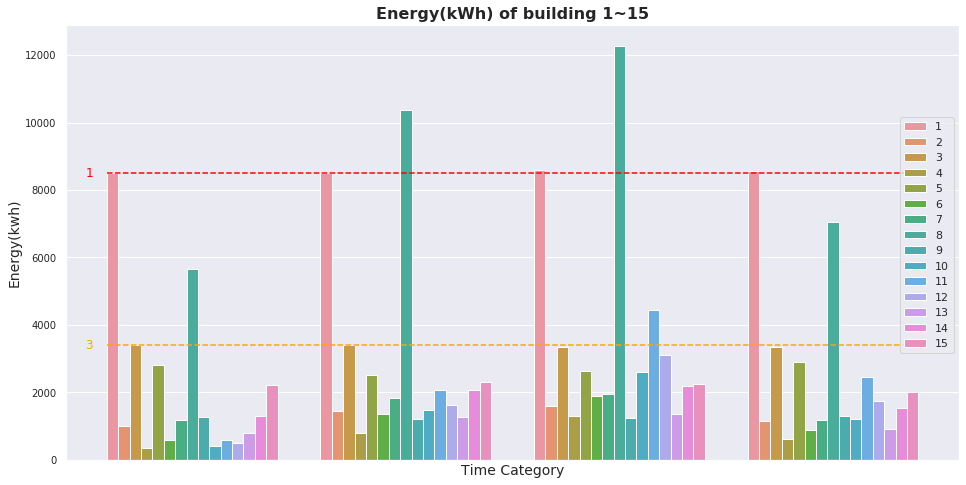

In [ ]:
# building number
bd_samples = df_processed[(df_processed['num']=='1') | (df_processed['num']=='2') | (df_processed['num']=='3') | 
                          (df_processed['num']=='4') | (df_processed['num']=='5') | (df_processed['num']=='6') | 
                          (df_processed['num']=='7') | (df_processed['num']=='8') | (df_processed['num']=='9') | 
                          (df_processed['num']=='10') | (df_processed['num']=='11') | (df_processed['num']=='12') | 
                          (df_processed['num']=='13') | (df_processed['num']=='14') | (df_processed['num']=='15')]

sns.set(style="darkgrid")
plt.figure(figsize=(16, 8))
sns.barplot(data=bd_samples, x='timecat', y='energy', hue='num', ci=None)

plt.legend(bbox_to_anchor=(1, 0.8))

plt.xticks(rotation=30, fontsize=10)
plt.yticks(fontsize=10)
ax = plt.gca()
ax.xaxis.set_major_locator(dates.DayLocator(interval=7))

ax.hlines(8500, -0.4, 3.4, color='red', ls='--')
plt.text(-0.5, 8400, '1', color='red')
ax.hlines(3400, -0.4, 3.4, color='orange', ls='--')
plt.text(-0.5, 3300, '3', color='orange')

plt.xlabel('Time Category', fontsize=14)
plt.ylabel('Energy(kwh)', fontsize=14)
plt.title('Energy(kWh) of building 1~15', fontsize=16, fontweight='bold');

In [ ]:
df_processed[(df_processed['num']=='1')]

,num,energy,temp,windspeed,humidity,precipitation,sunshine,non_elec_ac,pv,timecat,weekend
0,1,8179.056,17.6,2.5,92.0,0.8,0.0,0,0,night,0
1,1,8135.640,17.7,2.9,91.0,0.3,0.0,0,0,night,0
2,1,8107.128,17.5,3.2,91.0,0.0,0.0,0,0,night,0
3,1,8048.808,17.1,3.2,91.0,0.0,0.0,0,0,night,0
4,1,8043.624,17.0,3.3,92.0,0.0,0.0,0,0,night,0
...,...,...,...,...,...,...,...,...,...,...,...
2035,1,8714.952,29.4,3.4,66.0,0.0,0.2,0,0,evening,0
2036,1,8740.224,28.7,1.9,69.0,0.0,0.0,0,0,evening,0
2037,1,8730.504,28.3,1.1,71.0,0.0,0.0,0,0,evening,0
2038,1,8725.968,28.3,2.4,72.0,0.0,0.0,0,0,evening,0


In [ ]:
df_processed[(df_processed['num']=='3')]

,num,energy,temp,windspeed,humidity,precipitation,sunshine,non_elec_ac,pv,timecat,weekend
4080,3,3183.624000,17.0,2.0,100.0,1.1,0.0,1,1,night,0
4081,3,3171.636000,17.2,2.3,99.0,0.1,0.0,1,1,night,0
4082,3,3175.740000,17.2,3.7,98.0,0.0,0.0,1,1,night,0
4083,3,3194.856000,16.7,3.1,99.0,0.0,0.0,1,1,night,0
4084,3,3198.528000,16.9,3.5,98.0,0.0,0.0,1,1,night,0
...,...,...,...,...,...,...,...,...,...,...,...
6115,3,3572.334982,29.2,1.0,72.0,0.0,0.6,1,1,evening,0
6116,3,3571.432457,28.0,0.1,79.0,0.0,0.0,1,1,evening,0
6117,3,3569.301794,27.6,0.1,82.0,0.0,0.0,1,1,evening,0
6118,3,3549.660490,27.5,0.4,84.0,0.0,0.0,1,1,evening,0


## train/val/test 분리

In [ ]:
# train/val/test = 0.6/0.2/0/2
train, test = train_test_split(df_processed, test_size=0.4, random_state=14)
val, test = train_test_split(test, test_size=0.5, random_state=14)

In [ ]:
train.shape, val.shape, test.shape

((73440, 11), (24480, 11), (24480, 11))

In [ ]:
# target/feature
target = 'energy'
features = df_processed.drop(target, axis=1).columns

X_train, y_train = train[features], train[target]
X_val, y_val = val[features], val[target]
X_test, y_test = test[features], test[target]

In [ ]:
X_train

,num,temp,windspeed,humidity,precipitation,sunshine,non_elec_ac,pv,timecat,weekend
112465,56,21.2,0.0,89.0,0.0,0.0,0,1,night,0
59861,30,20.1,12.5,99.0,0.0,0.0,1,1,night,0
108113,53,32.7,1.5,61.0,0.0,0.9,1,0,afternoon,0
111657,55,24.9,1.1,98.0,0.7,0.0,1,1,morning,1
91916,46,24.4,2.0,64.0,0.0,0.0,1,0,evening,0
...,...,...,...,...,...,...,...,...,...,...
22855,12,19.7,1.1,92.0,0.0,0.0,1,1,morning,0
117142,58,25.0,2.4,71.0,0.0,0.0,1,0,evening,0
9484,5,20.4,3.2,91.0,0.0,0.0,1,0,night,1
79192,39,31.8,3.1,60.0,0.0,0.8,1,1,afternoon,1


In [ ]:
X_val

,num,temp,windspeed,humidity,precipitation,sunshine,non_elec_ac,pv,timecat,weekend
75530,38,18.2,1.8,89.0,0.0,0.0,1,1,night,0
67097,33,31.5,2.2,72.0,0.0,0.5,1,0,afternoon,1
110207,55,19.0,1.7,79.0,0.0,0.0,1,1,evening,0
97923,49,17.1,3.2,91.0,0.0,0.0,0,0,night,0
40007,20,22.6,0.8,89.0,0.0,0.0,0,0,evening,0
...,...,...,...,...,...,...,...,...,...,...
21139,11,20.6,4.0,83.0,0.0,0.0,0,0,evening,0
18729,10,26.6,1.5,41.0,0.0,1.0,1,0,morning,0
108262,54,22.2,2.0,75.0,0.0,0.0,1,0,evening,1
50022,25,19.2,0.9,96.0,0.0,0.0,1,0,morning,0


In [ ]:
X_test

,num,temp,windspeed,humidity,precipitation,sunshine,non_elec_ac,pv,timecat,weekend
107679,53,26.3,1.6,97.0,0.0,0.0,1,0,afternoon,0
7427,4,23.6,1.4,81.0,0.0,0.0,1,1,morning,1
69221,34,23.7,1.1,88.0,0.0,0.0,1,1,night,0
2485,2,26.3,4.1,53.0,0.0,0.9,1,0,afternoon,0
14504,8,23.8,1.4,58.0,0.0,0.7,1,1,morning,0
...,...,...,...,...,...,...,...,...,...,...
58489,29,21.5,0.1,98.0,1.0,0.0,0,0,night,0
42256,21,28.4,2.6,75.0,0.0,0.0,0,1,afternoon,0
111970,55,25.3,2.2,98.0,1.6,0.0,1,1,morning,1
13988,7,28.8,2.1,82.0,0.0,0.0,1,0,evening,0


## Model Selection

In [ ]:
# TargetEncoder
tencoder = TargetEncoder(min_samples_leaf=1, smoothing=1)
X_train_tencoded = tencoder.fit_transform(X_train, y_train)
X_val_tencoded = tencoder.transform(X_val, y_val)

In [ ]:
def eval_calculation(model):
  y_train_pred = model.predict(X_train_tencoded)
  train_mae = mean_absolute_error(y_train, y_train_pred)
  train_r2 = r2_score(y_train, y_train_pred)
  print(f'훈련 MAE: {train_mae:.2f}')
  print(f'훈련 R^2: {train_r2:.2f}', end='\n\n')

  y_val_pred = model.predict(X_val_tencoded)
  val_mae = mean_absolute_error(y_val, y_val_pred)
  val_r2 = r2_score(y_val, y_val_pred)
  print(f'검증 MAE: {val_mae:.2f}')
  print(f'검증 R^2: {val_r2:.2f}')

#### 기준모델=선형회귀

In [ ]:
lr = LinearRegression(n_jobs=-1)
lr.fit(X_train_tencoded, y_train)

LinearRegression(n_jobs=-1)

In [ ]:
# 평가지표 계산
eval_calculation(lr)

훈련 MAE: 492.26
훈련 R^2: 0.85

검증 MAE: 491.28
검증 R^2: 0.85


#### 릿지회귀

In [ ]:
ridge = Ridge(normalize=True)
ridge.fit(X_train_tencoded, y_train)

Ridge(normalize=True)

In [ ]:
# 평가지표 계산
eval_calculation(ridge)

훈련 MAE: 783.22
훈련 R^2: 0.64

검증 MAE: 782.47
검증 R^2: 0.64


#### 결정트리

In [ ]:
dtr = DecisionTreeRegressor(random_state=14, max_depth=5)
dtr.fit(X_train_tencoded, y_train)

DecisionTreeRegressor(max_depth=5, random_state=14)

In [ ]:
# 평가지표 계산
eval_calculation(dtr)

훈련 MAE: 460.55
훈련 R^2: 0.89

검증 MAE: 453.38
검증 R^2: 0.90


#### 랜덤포레스트

In [ ]:
rfr = RandomForestRegressor(random_state=14, max_depth=5)
rfr.fit(X_train_tencoded, y_train)

RandomForestRegressor(max_depth=5, random_state=14)

In [ ]:
# 평가지표 계산
eval_calculation(rfr)

훈련 MAE: 450.63
훈련 R^2: 0.90

검증 MAE: 443.63
검증 R^2: 0.90


#### AdaBoost

In [ ]:
adr = AdaBoostRegressor(random_state=14)
adr.fit(X_train_tencoded, y_train)

AdaBoostRegressor(random_state=14)

In [ ]:
# 평가지표 계산
eval_calculation(adr)

훈련 MAE: 576.60
훈련 R^2: 0.85

검증 MAE: 573.17
검증 R^2: 0.86


#### XGBRegressor

In [ ]:
xgbr = XGBRegressor(random_state=14, max_depth=5)
xgbr.fit(X_train_tencoded, y_train)

[04:14:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=5, random_state=14)

In [ ]:
# 평가지표 계산
eval_calculation(xgbr)

훈련 MAE: 317.90
훈련 R^2: 0.95

검증 MAE: 319.37
검증 R^2: 0.94


## XGBRegressor 하이퍼 파라미터 조정

In [ ]:
# # TargetEncoder 사용
# pipe = make_pipeline(
#     TargetEncoder(),  
#     XGBRegressor(random_state=14)
# )

In [ ]:
# OrdinalEncoder 사용
pipe = make_pipeline(
    OrdinalEncoder(),  
    XGBRegressor(random_state=14)
)

#### 검증곡선을 통한 max_depth 파악

In [ ]:
depth = range(1, 30, 2)

ts, vs = validation_curve(
    pipe, X_train, y_train
    , param_name='xgbregressor__max_depth'
    , param_range=depth, scoring='neg_mean_absolute_error'
    , cv=5
    , n_jobs=-1
)

train_scores_mean = np.mean(-ts, axis=1)
validation_scores_mean = np.mean(-vs, axis=1)

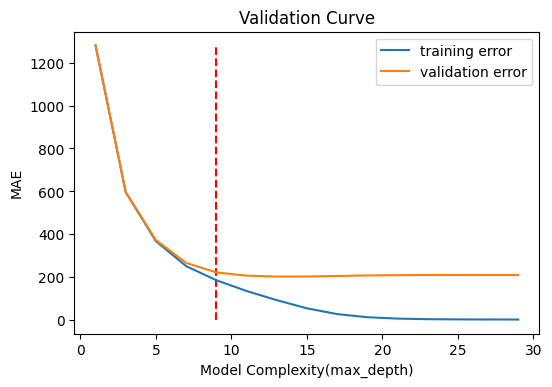

In [ ]:
fig, ax = plt.subplots()

# 훈련세트 검증곡선
ax.plot(depth, train_scores_mean, label='training error')

# 검증세트 검증곡선
ax.plot(depth, validation_scores_mean, label='validation error')

# 이상적인 max_depth
ax.vlines(9, 0, train_scores_mean.max(), color='red', ls='--')

# 그래프 셋팅
ax.set(title='Validation Curve'
      , xlabel='Model Complexity(max_depth)', ylabel='MAE')
ax.legend()
fig.dpi = 100

#### Early Stopping으로 n_estimators 최적화

In [ ]:
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_val_encoded = encoder.transform(X_val, y_val)

In [ ]:
model = XGBRegressor(
    n_estimators=1000,
    max_depth=9,
    learning_rate=0.1,
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          eval_metric='mae',
          early_stopping_rounds=50
         )

[04:38:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:2096.22	validation_1-mae:2100.22
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:1887.21	validation_1-mae:1890.45
[2]	validation_0-mae:1699.74	validation_1-mae:1702.65
[3]	validation_0-mae:1533.08	validation_1-mae:1535.24
[4]	validation_0-mae:1383.02	validation_1-mae:1384.61
[5]	validation_0-mae:1250.8	validation_1-mae:1252.63
[6]	validation_0-mae:1133.73	validation_1-mae:1135.41
[7]	validation_0-mae:1029.24	validation_1-mae:1030.94
[8]	validation_0-mae:938.903	validation_1-mae:941.18
[9]	validation_0-mae:856.835	validation_1-mae:859.058
[10]	validation_0-mae:786.12	validation_1-mae:789.384
[11]	validation_0-mae:723.12	validation_1-mae:726.324
[12]	validation_0-mae:665.489	validation_1-mae:668.766
[13]	validation

XGBRegressor(max_depth=9, n_estimators=1000, n_jobs=-1)


#### Randomized Search CV로 기타 하이퍼파라미터 튜닝

In [ ]:
# OrdinalEncoder 사용
dists = {
    'xgbregressor__learning_rate': [0.01, 0.03, 0.05],
    'xgbregressor__n_estimators': [453],
    'xgbregressor__max_depth': [9],
    'xgbregressor__max_features': uniform(0, 1)
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=10, 
    cv=5, 
    scoring='neg_mean_absolute_error',  
    verbose=1,
    n_jobs=-1
)

In [ ]:
clf.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[08:42:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print('최적 하이퍼파라미터: ', clf.best_params_)

최적 하이퍼파라미터:  {'xgbregressor__learning_rate': 0.05, 'xgbregressor__max_depth': 9, 'xgbregressor__max_features': 0.6245950176504151, 'xgbregressor__n_estimators': 453}


#### 최종 모델 선택

In [ ]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,0,7,9,2,3,1,4,5,6,8
mean_fit_time,65.309991,65.113602,65.150863,68.184227,66.702682,70.064871,70.637218,69.635203,70.053904,69.882037
std_fit_time,1.462171,1.08195,1.020554,3.352783,1.460037,0.875243,1.046741,1.701257,1.05403,1.079867
mean_score_time,1.478741,1.516081,1.337795,1.478979,1.486752,1.581857,1.694921,1.622929,1.659912,1.554059
std_score_time,0.042055,0.072413,0.17207,0.032309,0.050004,0.057872,0.05829,0.059787,0.100449,0.067014
param_xgbregressor__learning_rate,0.05,0.05,0.05,0.03,0.03,0.01,0.01,0.01,0.01,0.01
param_xgbregressor__max_depth,9,9,9,9,9,9,9,9,9,9
param_xgbregressor__max_features,0.624595,0.266946,0.232564,0.595558,0.392766,0.275685,0.798673,0.37817,0.011672,0.1721
param_xgbregressor__n_estimators,453,453,453,453,453,453,453,453,453,453
params,"{'xgbregressor__learning_rate': 0.05, 'xgbregr...","{'xgbregressor__learning_rate': 0.05, 'xgbregr...","{'xgbregressor__learning_rate': 0.05, 'xgbregr...","{'xgbregressor__learning_rate': 0.03, 'xgbregr...","{'xgbregressor__learning_rate': 0.03, 'xgbregr...","{'xgbregressor__learning_rate': 0.01, 'xgbregr...","{'xgbregressor__learning_rate': 0.01, 'xgbregr...","{'xgbregressor__learning_rate': 0.01, 'xgbregr...","{'xgbregressor__learning_rate': 0.01, 'xgbregr...","{'xgbregressor__learning_rate': 0.01, 'xgbregr..."
split0_test_score,-217.720375,-217.720375,-217.720375,-224.097005,-224.097005,-276.20959,-276.20959,-276.20959,-276.20959,-276.20959


In [ ]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').iloc[0]

mean_fit_time                                                                65.309991
std_fit_time                                                                  1.462171
mean_score_time                                                               1.478741
std_score_time                                                                0.042055
param_xgbregressor__learning_rate                                                 0.05
param_xgbregressor__max_depth                                                        9
param_xgbregressor__max_features                                              0.624595
param_xgbregressor__n_estimators                                                   453
params                               {'xgbregressor__learning_rate': 0.05, 'xgbregr...
split0_test_score                                                          -217.720375
split1_test_score                                                          -212.058546
split2_test_score                          

In [ ]:
bestmodel = clf.best_estimator_

In [ ]:
y_train_pred = bestmodel.predict(X_train)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
print(f'훈련 MAE: {train_mae:.2f}')
print(f'훈련 R^2: {train_r2:.2f}', end='\n\n')

y_val_pred = bestmodel.predict(X_val)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
print(f'검증 MAE: {val_mae:.2f}')
print(f'검증 R^2: {val_r2:.2f}')

훈련 MAE: 158.44
훈련 R^2: 0.98

검증 MAE: 207.26
검증 R^2: 0.96


## 모델 해석

#### Test 예측

In [ ]:
# 모델 성능 예측
y_test_pred = bestmodel.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f'테스트 MAE: {test_mae:.2f}')
print(f'테스트 R^2: {test_r2:.2f}')

테스트 MAE: 209.69
테스트 R^2: 0.96


In [ ]:
# 기준모델 예측
X_test_encoded = tencoder.transform(X_test, y_test)
y_test_pred = lr.predict(X_test_encoded)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f'테스트 MAE: {test_mae:.2f}')
print(f'테스트 R^2: {test_r2:.2f}')

테스트 MAE: 486.84
테스트 R^2: 0.85


#### Permutation Importance 확인

In [ ]:
bestmodel.named_steps

{'ordinalencoder': OrdinalEncoder(cols=['num', 'timecat'],
                mapping=[{'col': 'num', 'data_type': dtype('O'),
                          'mapping': 56      1
 30      2
 53      3
 55      4
 46      5
        ..
 60     57
 59     58
 20     59
 10     60
 NaN    -2
 Length: 61, dtype: int64},
                         {'col': 'timecat', 'data_type': dtype('O'),
                          'mapping': night        1
 afternoon    2
 morning      3
 evening      4
 NaN         -2
 dtype: int64}]),
 'xgbregressor': XGBRegressor(learning_rate=0.05, max_depth=9, max_features=0.6245950176504151,
              n_estimators=453, random_state=14)}

In [ ]:
permuter = PermutationImportance(
    bestmodel.named_steps['xgbregressor'],
    scoring='neg_mean_absolute_error',
    n_iter=5,
    random_state=14
)

X_test_transformed = bestmodel.named_steps['ordinalencoder'].transform(X_test)

permuter.fit(X_test_transformed, y_test);

In [ ]:
eli5.show_weights(
    permuter, 
    top=None,
    feature_names=X_test_transformed.columns.tolist()
)

Weight,Feature
1466.1043 ± 4.3918,num
270.9259 ± 5.8168,timecat
232.4892 ± 3.8004,pv
217.9684 ± 4.0118,non_elec_ac
148.0791 ± 1.7374,temp
109.6768 ± 5.6711,weekend
40.7878 ± 2.1829,humidity
25.8669 ± 1.4024,windspeed
24.3881 ± 0.9805,sunshine
7.8757 ± 0.5572,precipitation


#### 카테고리값 PDP

In [ ]:
features = ['timecat', 'num']

interaction = pdp_interact(
    model=bestmodel.named_steps['xgbregressor'], 
    dataset=X_test_encoded,
    model_features=X_test_encoded.columns, 
    features=features
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


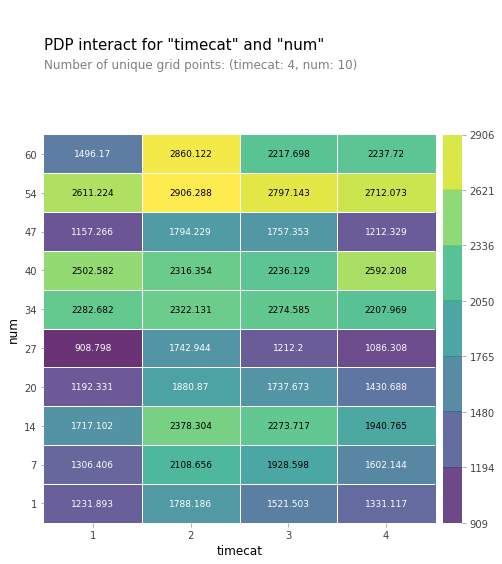

In [ ]:
pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [ ]:
feature = 'timecat'

for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping'] # Series
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

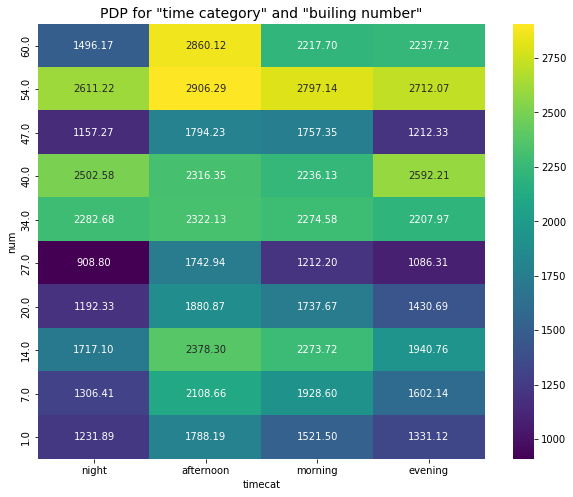

In [ ]:
pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], 
    index=features[1]
)[::-1]

pdp = pdp.rename(columns=dict(zip(category_codes, category_names)))
plt.figure(figsize=(10, 8))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title('PDP for "time category" and "builing number"', fontsize=14);

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


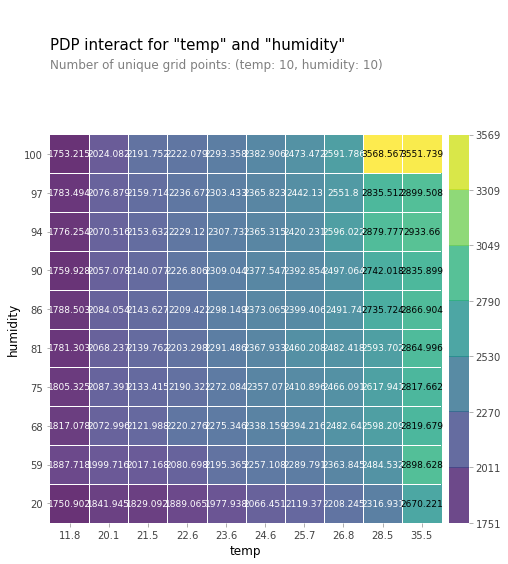

In [ ]:
features = ['temp', 'humidity']

interaction = pdp_interact(
    model=model, 
    dataset=X_test_encoded,
    model_features=X_test_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

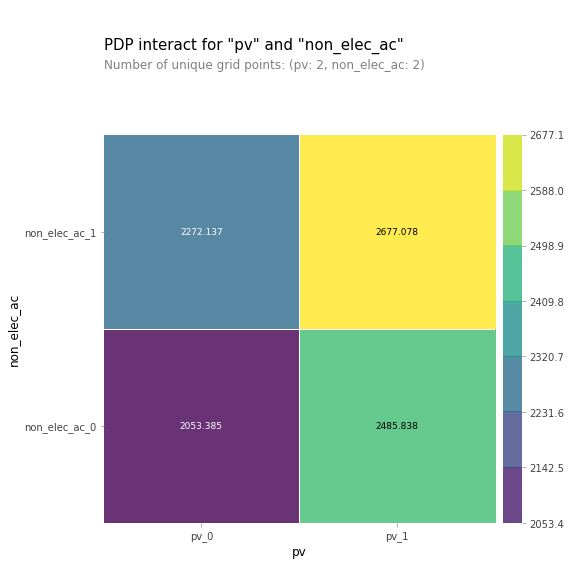

In [ ]:
features = ['pv', 'non_elec_ac']

interaction = pdp_interact(
    model=model, 
    dataset=X_test_encoded,
    model_features=X_test_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

#### Shap

In [ ]:
# test 샘플: 14번째 데이터 확인
row = X_test.iloc[[14]]
row

,num,temp,windspeed,humidity,precipitation,sunshine,non_elec_ac,pv,timecat,weekend
836,1,24.7,1.9,61.0,0.0,0.4,0,0,evening,1


In [ ]:
# 실제값
y_test.iloc[[14]]

836    8510.184
Name: energy, dtype: float64

In [ ]:
# 예측값
bestmodel.predict(row)

array([8591.119], dtype=float32)

In [ ]:
# shap 사용을 위해 pipeline 사용하지 않도록 분리
encoder = bestmodel.named_steps['ordinalencoder']
X_test_encoded = encoder.transform(X_test, y_test)
row_encoded = X_test_encoded.iloc[[14]]

model = bestmodel.named_steps['xgbregressor']

model.fit(X_test_encoded, y_test)

[08:52:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.05, max_depth=9, max_features=0.6245950176504151,
             n_estimators=453, random_state=14)

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row_encoded)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

In [ ]:
# 100개 샘플로 확인
shap_values = explainer.shap_values(X_test_encoded.iloc[:100])

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_test_encoded.iloc[:100])

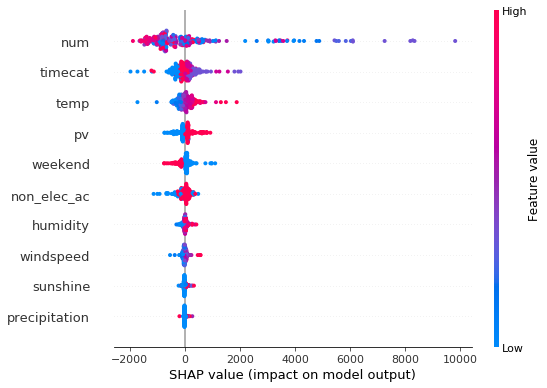

In [ ]:
shap_values = explainer.shap_values(X_test_encoded.iloc[:300])
shap.summary_plot(shap_values, X_test_encoded.iloc[:300])

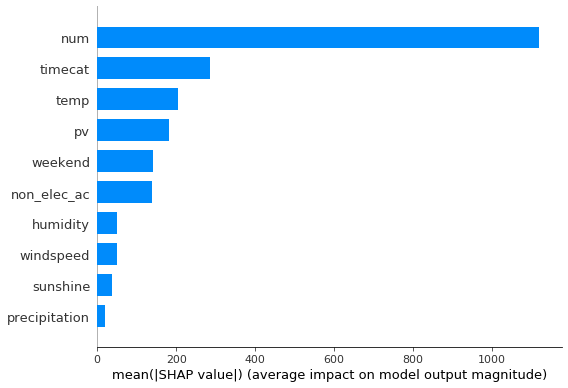

In [ ]:
shap.summary_plot(shap_values, X_test_encoded.iloc[:300], plot_type="bar")

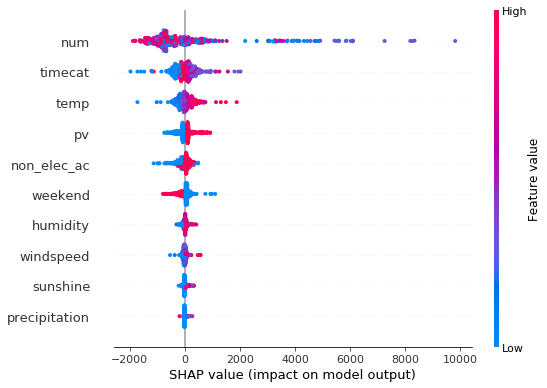

In [ ]:
shap_values = explainer.shap_values(X_test_encoded.iloc[:500])
shap.summary_plot(shap_values, X_test_encoded.iloc[:500])

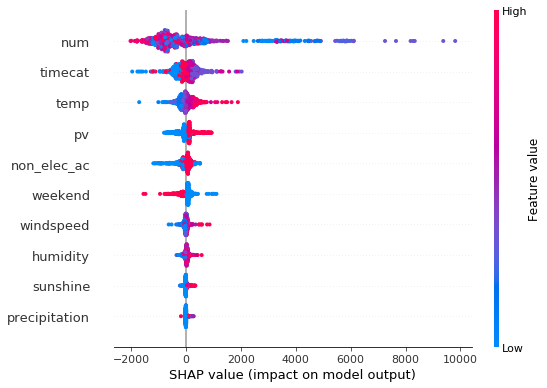

In [ ]:
shap_values = explainer.shap_values(X_test_encoded.iloc[:1000])
shap.summary_plot(shap_values, X_test_encoded.iloc[:1000])